# Deep Learning NLP - Labs

Text Clustering with K-Means and GloVe Word Embeddings using Autoencoders

This exercise aims to show the use of RNNs and embeddings on a text clustering task (NLP).

The dataset is part of the [Youth Mental Health Narratives](https://www.drivendata.org/competitions/group/cdc-narratives/) project.

<br>

Documentation:
* **Embedding models** (topic modelling) in [Gensim library](https://github.com/piskvorky/gensim-data?tab=readme-ov-file#models)

<br>
@Ricardo Almeida

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [3]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import gensim.downloader as api
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize

In [4]:
nltk.download('punkt_tab') # 'punkt'

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ricardo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
text_column = 'NarrativeCME'

#### 1. Loading dataset

In [6]:
df = pd.read_csv("features_Z140Hep.csv")

In [51]:
#df

In [8]:
df = df[[text_column]]

In [52]:
#df

In [10]:
df = df.copy()

#### 2. Download and load pre-trained GloVe model

In [ ]:
# Downloading and loading the "glove-wiki-gigaword-300" model
glove_model = api.load("glove-wiki-gigaword-300")  # GloVe model pre-trained on Wikipedia

#### 3. Compute document embeddings by averaging word embeddings

In [ ]:
def get_document_embedding(text, glove_model):
    words = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    word_embeddings = [glove_model[word] for word in words if word in glove_model]  # Get embeddings for known words
    if word_embeddings:  # If there are valid word embeddings, take their average
        return np.mean(word_embeddings, axis=0)
    else:  # Fallback if no known words
        return np.zeros(glove_model.vector_size)

In [32]:
# Generate embeddings for each document in 'analyze_text'
df['embedding'] = df[text_column].apply(lambda x: get_document_embedding(x, glove_model))
embeddings = np.vstack(df['embedding'].values)  # Stack into a 2D array for further processing

#### 4. Define and train Autoencoder for dimensionality reduction

In [ ]:
# Setting up an Autoencoder with a bottleneck layer for 2D representation
input_dim = embeddings.shape[1]
encoding_dim = 2  # Compress to 2D for visualization

# Build Autoencoder Model
autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(encoding_dim, activation='relu'),  # Bottleneck layer for 2D embedding
    layers.Dense(64, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

# Compile Autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Train Autoencoder
autoencoder.fit(embeddings, embeddings, epochs=10, batch_size=32, verbose=1)

In [36]:
# Extract 2D embeddings from Bottleneck Layer
encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.layers[2].output)
reduced_embeddings_autoencoder = encoder.predict(embeddings)

125/125 [==============================] - 0s 3ms/step


#### 5. K-Means Clustering on reduced embeddings

In [ ]:
# Using K-Means to detect clusters of semantically similar content
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42)  # Assume 3 clusters for example
labels = kmeans.fit_predict(reduced_embeddings_autoencoder)

In [55]:
# Assign Clusters to the DataFrame
df['cluster'] = labels

In [41]:
# Split the DataFrame into K Groups (Based on Cluster Labels)
# Split into K groups based on the unique cluster labels from K-Means
clustered_groups = [df[df['cluster'] == k] for k in set(labels)]

#### 6. Visualize clusters with Autoencoder embeddings

In [ ]:
# Plot the 2D embeddings and color by cluster
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_embeddings_autoencoder[:, 0], reduced_embeddings_autoencoder[:, 1], c=labels, cmap='viridis')
plt.colorbar(label="Cluster Label")
plt.title("K-Means Clustering of Text Sections (Autoencoder 2D Embeddings)")
plt.xlabel("Autoencoder Component 1")
plt.ylabel("Autoencoder Component 2")
plt.show()

#### 7. Summary of clusters

In [ ]:
for idx, group in enumerate(clustered_groups):
    print(f"\nCluster {idx} - Number of sections: {len(group)}")
    print(group[text_column].head(3))  # Print first 3 sections in each cluster

Cluster 0 Keywords: head, hanging, gunshot, scene, history, mother, residence, girlfriend, prior, ems
Cluster 1 Keywords: hanging, head, history, gunshot, scene, suicidal, ems, pronounced, toxicology, depression
Cluster 2 Keywords: head, gunshot, mother, hanging, girlfriend, father, scene, home, history, prior


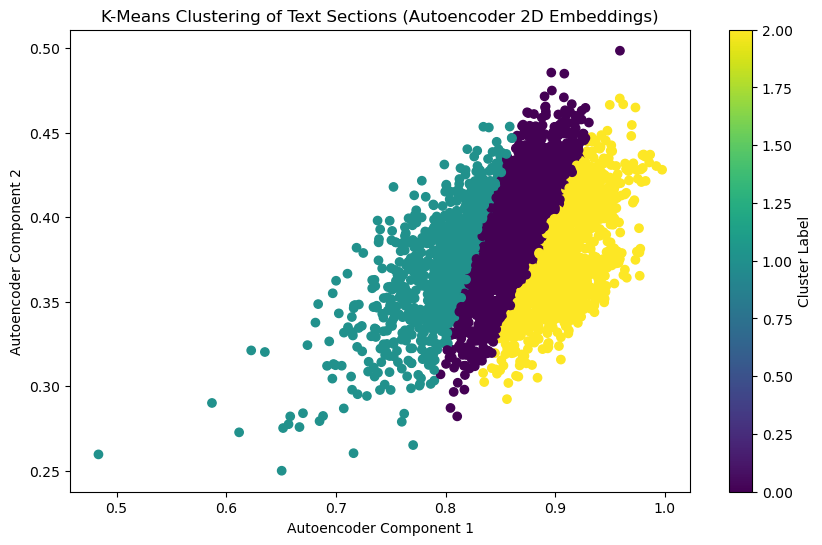


Cluster 0 - Number of sections: 1915
0    V (XX XX) shot himself in a motor vehicle.The ...
1    V was XXXX.  V was found in the basement of hi...
2    V was XXXX. V was found in his residence suffe...
Name: NarrativeCME, dtype: object

Cluster 1 - Number of sections: 789
4     XX XX V found deceased at home by his grandpar...
6     The victim was a XX, XX.  He was a combat vete...
12    DC notes ALCOHOL IMPAIRMENT (0.062 PERCENT)The...
Name: NarrativeCME, dtype: object

Cluster 2 - Number of sections: 1296
3    On the day of the fatal event in the early mor...
7    The victim was a XX, XX.  The victim committed...
8    The victim was an XX, XX.  The victim committe...
Name: NarrativeCME, dtype: object


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the blacklist of words you want to exclude from the analysis
blacklist = {'v', 'v1', 'v2', 'xxxx', 'xx', 'death', 'suicide', 'victim', 'found', 'wound'}

# Combine blacklist with the default English stop words
tfidf_vectorizer = TfidfVectorizer(stop_words='english')  # Initialize with English stop words
all_stop_words = list(set(tfidf_vectorizer.get_stop_words()).union(blacklist))  # Combine with blacklist

# Reinitialize the TfidfVectorizer with the combined stop words
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words)

# Store the top N keywords for each cluster
top_n_keywords = 10  # Number of top keywords to extract per cluster
cluster_keywords = {}

# Loop through each cluster and extract the top N keywords using TF-IDF
for cluster_num in range(kmeans.n_clusters):
    cluster_docs = df[df['cluster'] == cluster_num][text_column]
    
    # Fit the TF-IDF model on the documents of the cluster
    tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_docs)
    
    # Get feature names (words)
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    
    # Sum TF-IDF scores across all documents in the cluster
    tfidf_scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
    
    # Get indices of top N keywords based on TF-IDF scores
    top_indices = np.argsort(tfidf_scores)[::-1][:top_n_keywords]
    
    # Get the top N keywords
    top_keywords = feature_names[top_indices]
    
    # Store the keywords for the cluster
    cluster_keywords[cluster_num] = top_keywords

# Step 10: Display Cluster Keywords
for cluster_num, keywords in cluster_keywords.items():
    print(f"Cluster {cluster_num} Keywords: {', '.join(keywords)}")

# Step 11: Visualize Clusters with Autoencoder Embeddings
# Plot the 2D embeddings and color by cluster
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_embeddings_autoencoder[:, 0], reduced_embeddings_autoencoder[:, 1], c=labels, cmap='viridis')
plt.colorbar(label="Cluster Label")
plt.title("K-Means Clustering of Text Sections (Autoencoder 2D Embeddings)")
plt.xlabel("Autoencoder Component 1")
plt.ylabel("Autoencoder Component 2")
plt.show()

# Step 12: Split the DataFrame into K Groups (Based on Cluster Labels)
# Split into K groups based on the unique cluster labels from K-Means
clustered_groups = [df[df['cluster'] == k] for k in set(labels)]

# Show a summary of clusters
for idx, group in enumerate(clustered_groups):
    print(f"\nCluster {idx} - Number of sections: {len(group)}")
    print(group[text_column].head(3))